# Variational Autoencoder in TensorFlow

Slightly modified from https://jmetzen.github.io/2015-11-27/vae.html mostly to improve readability

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

In [4]:
class VariationalAutoencoder(object):
    
    def __init__(self, model, transfer_fct=tf.nn.softplus, learning_rate=0.001, batch_size=100):
        self.model = model
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        self.x = tf.placeholder(tf.float32, [None, model["n_input"]])
        
        self.create_network()
        self.create_loss_optimizer()
        
        init = tf.initialize_all_variables()

        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def create_network(self):
        # Initialize autoencode network weights and biases
        weights = self.init_weights(**self.model)

        self.z_mean, self.z_log_sigma_sq = self.recognition_network(weights["w_recog"], weights["b_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.model["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.z_mean, tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = self.generator_network(weights["w_gener"], weights["b_gener"])
            
            
    def init_weights(self, n_hid_recog_1, n_hid_recog_2, n_hid_gener_1,  n_hid_gener_2, n_input, n_z):
        weights = dict()
        weights['w_recog'] = {
            'h1'           : tf.Variable(xavier_init(n_input, n_hid_recog_1)),
            'h2'           : tf.Variable(xavier_init(n_hid_recog_1, n_hid_recog_2)),
            'out_mean'     : tf.Variable(xavier_init(n_hid_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hid_recog_2, n_z))}
        weights['b_recog'] = {
            'b1'           : tf.Variable(tf.zeros([n_hid_recog_1], dtype=tf.float32)),
            'b2'           : tf.Variable(tf.zeros([n_hid_recog_2], dtype=tf.float32)),
            'out_mean'     : tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        weights['w_gener'] = {
            'h1'           : tf.Variable(xavier_init(n_z, n_hid_gener_1)),
            'h2'           : tf.Variable(xavier_init(n_hid_gener_1, n_hid_gener_2)),
            'out_mean'     : tf.Variable(xavier_init(n_hid_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hid_gener_2, n_input))}
        weights['b_gener'] = {
            'b1'           : tf.Variable(tf.zeros([n_hid_gener_1], dtype=tf.float32)),
            'b2'           : tf.Variable(tf.zeros([n_hid_gener_2], dtype=tf.float32)),
            'out_mean'     : tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return weights
    
    def recognition_network(self, weights, biases):
        # Maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']), biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def generator_network(self, weights, biases):
        # Generate probabilistic decoder, which maps points in latent space 
        # onto a Bernoulli distribution in data space.The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),  biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) 
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        return x_reconstr_mean
            
    def create_loss_optimizer(self):
        # Reconstruction loss (the negative log probability of the input under the reconstructed 
        # Bernoulli distribution induced by the decoder in the data space. This can be interpreted 
        # as the number of "nats" required for reconstructing the input when the activation in latent
        # is given. Adding 1e-10 to avoid evaluation of log(0.0)
        # page 5 of https://arxiv.org/abs/1312.6114, right part of r.h.s. (10)
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)
        
        # Latent loss: KL divergence between the distribution 
        # in latent space induced by the encoder on the data and some prior. 
        # This acts as a kind of regularizer. 
        # page 5 of https://arxiv.org/abs/1312.6114, left part of r.h.s. (10)
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        _, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost
    
    def data_to_latent(self, X):
        # Transform data by mapping it into the latent space.
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        # z_mu is not None, take it from prior               
        if z_mu is None:
            z_mu = np.random.normal(size=self.model["n_z"])
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})

In [5]:
def train(model, learning_rate=0.001, batch_size=100, training_epochs=100, display_step=5):
    vae = VariationalAutoencoder(model, learning_rate=learning_rate, batch_size=batch_size)
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        n_batch = int(n_samples / batch_size)

        for i in range(n_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size

        if epoch % display_step == 0:
            print("Epoch:", '%03d' % (epoch), "cost =", "{:.9f}".format(avg_cost))
    return vae

In [6]:
model = dict(n_hid_recog_1=500, n_hid_recog_2=500, n_hid_gener_1=500, n_hid_gener_2=500, n_input=784, n_z=20)
vae = train(model, training_epochs=10)

Epoch: 000 cost = 183.078563454
Epoch: 005 cost = 109.915329104


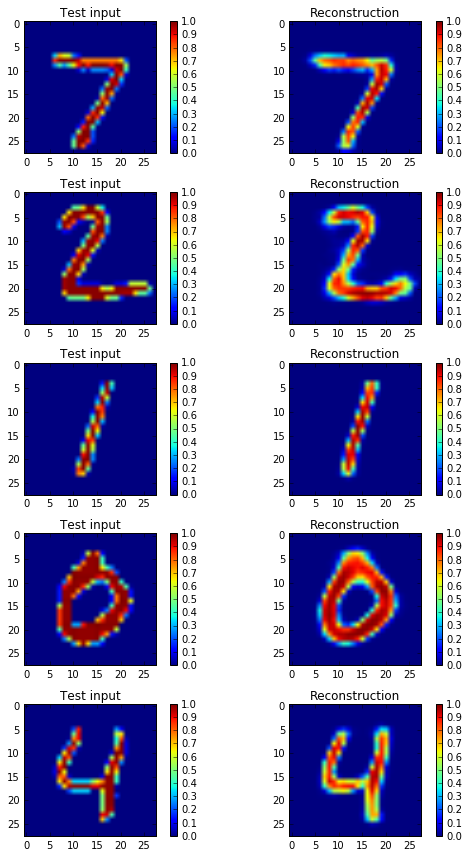

In [7]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [8]:
vae.sess.close()

## Structure of latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [9]:
model = dict(n_hid_recog_1=500, n_hid_recog_2=500, n_hid_gener_1=500, n_hid_gener_2=500, n_input=784, n_z=2)
vae_2d = train(model, training_epochs=100)

Epoch: 000 cost = 192.015845559
Epoch: 005 cost = 153.382671953
Epoch: 010 cost = 148.742308294
Epoch: 015 cost = 146.196942499
Epoch: 020 cost = 144.417738370
Epoch: 025 cost = 143.242187944
Epoch: 030 cost = 142.226268394
Epoch: 035 cost = 141.425313721
Epoch: 040 cost = 140.801385498
Epoch: 045 cost = 140.318193762
Epoch: 050 cost = 139.905897675
Epoch: 055 cost = 139.482627203
Epoch: 060 cost = 139.100066015
Epoch: 065 cost = 138.763456088
Epoch: 070 cost = 138.573631411
Epoch: 075 cost = 138.236819860
Epoch: 080 cost = 138.030198253
Epoch: 085 cost = 137.769638478
Epoch: 090 cost = 137.587797019
Epoch: 095 cost = 137.380071633


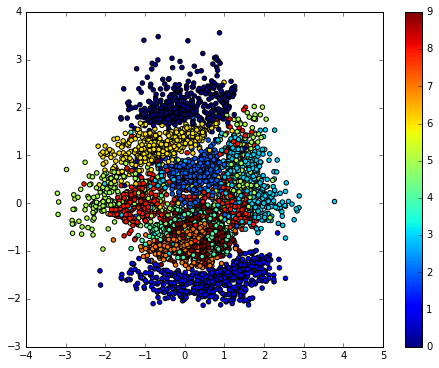

In [10]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.data_to_latent(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()

### Each digit is a reconstruction from this exact latent space

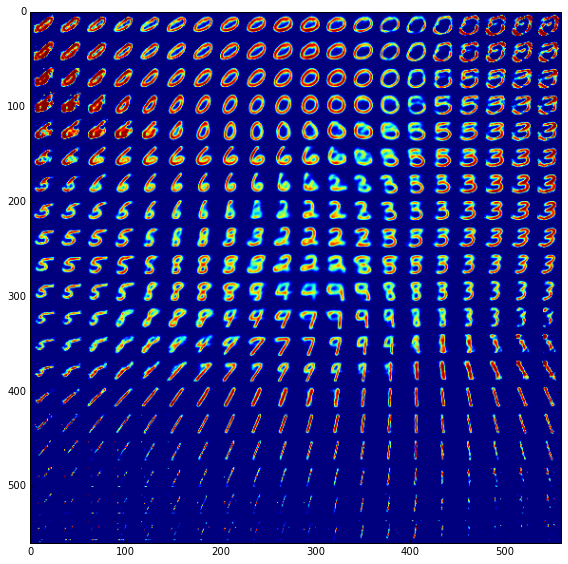

In [11]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi] for i in range(100)]) # ugly hack to get 100 batch size
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[i].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()

In [12]:
vae_2d.sess.close()